In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
pd.options.mode.chained_assignment = None #default = 'warn'

sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

# Problem Set 5.1

This Problem Set is a two parter. In the first part you will apply ETL/EDA/Mathematical Modeling (Labs 5 and 6) to a new data set.
Each part is a separate grade.
Take all your PS3 comments into account.

## Directions

1. Show all work/steps/calculations using a combination of code and Markdown.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**


<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>This part of the Problem Set covers Labs 5 and 6. You get even less help this time. You should just know what to do.</p>
    <p>Additionally, this is a <em>report</em>, a narrative description of your process and findings. Use full sentences. Limit bullet lists. You should be able to "hide code" and have the remaining text make sense.</p></div>

<a id="contents"></a>
# Contents

1. [ETL](#step1)
2. [EDA](#step2)
3. [Null and Distributional Models](#step3)

## 1.1 - <a id="step1">ETL</a>
<a href="#contents">^ Contents</a>

Let's first start by taking a look at the data and names files we've read in. Since these are text files, I'm going to manually take a quick peek at these files.

From our names file, we have our attribute information for our data.

```
Description of fields in auto mpg data.

Name            Data Type
----            ---------
mpg             continuous
cylinders       multi-valued discrete
displacement    continuous
horsepower      continuous
weight          continuous
acceleration    continuous
model year      multi-valued discrete
origin          multi-valued discrete
car name        string (unique for each instance)
```

So we have 9 different variables in this dataset (most appear to be numeric). We know from our names file that there should be 398 instances/observations, and the $horsepower$ variable has 6 missing values.

We will cover these in more detail during the EDA process. For now let's try reading in the data. 

In [3]:
auto_mpg_data

'https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt'

This is indeed a text file with some data in it. Our first step should be getting our data into tidy data. Since there is an inconsistent amount of whitespace between each entry for any particular observation, we can tell our `pd.read_csv()` method to consider any whitespace between a value as a separator. (I initially used the `delim_whitespace=True` parameter, though that seems to be depreciated in favor of `\s+` now).

Since there are no headers in this text file, I will manually add the columns to our dataframe, using the description that we found above in our names file.

In [4]:
columns = [
    'mpg', 
    'cylinders', 
    'displacement', 
    'horsepower',
    'weight', 
    'acceleration', 
    'model year',
    'origin', 
    'car name'
]

data = pd.read_csv(auto_mpg_data, sep='\s+', header=None, names=columns)

We'll check the first few entries to make sure our data has been read in properly.

In [5]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Looks like we got most of what we need. We have 9 columns to represent each feature/attribute. We can also look at the information provided here with the `info()` method.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


We do in fact see 398 rows for each attribute. Most variables are floats or integers, with the exceptions of $horsepower$ and $car name$, the latter which we expect to be strings, so this is not unexpected. But we know $horsepower$ has 6 missing values somewhere. How should we handle this? I'm going to simply look at our observations first, where $horsepower$ does not have a value (from peeking at the data text file, I know the missing values are coded as a '?').

In [7]:
data[data['horsepower'] == '?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


We do in fact only have 6 observations here. Because that's only (6/398) = 0.015, or about 1.5% of our data, I will consider imputation for these 6 values with the median of $horsepower$. Note I'm choosing to use median instead of the mean since the median is a more robust statistic. This should not create inliers or other data abnormalities such as loss of variation since there are only a small number of missing values. We might turn to some domain knowledge to think about whether our median is a good estimate for these missing values.

[Average Horsepower of a Car Over the Years](https://carbuzz.com/features/average-horsepower-of-a-car-over-the-years/)

In this article, we get different ranges for the average horsepower of cars in the United States, mostly broken down by decade. To summarize, the 50s started out with an average of about 100 horsepower, and only went up to about 120hp by the 80s. Later decades saw a bit of increase, where the average could be considered closer to 175hp or so, but this might at least give us an idea if we're on the mark with imputing our missing values.

I know this is kind of blending into the EDA portion a bit, so I will just replace the missing values with our median here, and as long as we have our tidy data, we can start the EDA process and go more in depth with horsepower in the next section.

We need to select all the other 392 rows that don't include the 6 missing values in order to get the median for $horsepower$.

In [8]:
data_no_missing = data[data['horsepower'] != '?']

Since the $horsepower$ variable was a mix of strings and floats, it caused all the values to become strings. We fix this below so we can perform the numpy operations on this column.

In [9]:
data_no_missing['horsepower'] = data_no_missing['horsepower'].astype('float64')

Here we can finally find the median of $horsepower$ without the missing values. 

In [10]:
np.median(data_no_missing['horsepower'])

93.5

It's 93.5, which seems like a reasonable guess for our missing values, if not slightly on the low side, remembering that we theorized average car horsepowers range between 100-200, very roughly. (Again, we could also look at the median model years for the cars to get a better rough estimate, but I think that's getting too much into the EDA portion of things).

Finally, we can replace our missing values with our median of 93.5 and convert the column into a float type to prepare for our EDA.

In [11]:
data = data.replace('?', '93.5')
data['horsepower'] = data['horsepower'].astype('float64')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


We can see that our $horsepower$ variable is now a float64 type instead of object like it was originally. We are ready to move on to EDA now.

## 1.2 - <a id="step2">EDA</a>
<a href="#contents">^ Contents</a>

## Single Variable EDA

<a id="contents"></a>

* [MPG](#mpg)
* [Cylinders](#cylinders)
* [Displacement](#displacement)
* [Horsepower](#horsepower)
* [Weight](#weight)
* [Acceleration](#acceleration)
* [Model Year](#year)
* [Origin](#origin)
* [Car Name](#name)

## Pairwise EDA

<a id="contents"></a>

* [MPG vs Cylinders](#mpg_cylinders)
* [MPG vs Displacement](#mpg_displacement)
* [MPG vs Horsepower](#mpg_horsepower)
* [MPG vs Weight](#mpg_weight)
* [MPG vs Acceleration](#mpg_acceleration)
* [MPG vs Model Year](#mpg_year)
* [MPG vs Origin](#mpg_origin)
* [MPG vs Car Name](#mpg_name)

For our EDA, we'll start with single variable EDA and just go down the list, followed by pairwise EDA with our target variable ($mpg$). First up for single variable EDA is $mpg$.

Before we start, we might guess as to how each variable could affect $mpg$ similar to a causal loop diagram. I don't want to focus on the diagram here, but I'll list out some relationships that might be important, based on my own domain knowledge.

<ul>
    <li>cylinders -> (-) mpg: more cylinders generally means higher fuel usage and thus less efficient mpg.
    <li>horsepower -> (-) mpg: similar to cylinders, higher horsepower generally means more fuel usage, so we might expect cars with high horsepower to have lower values of mpg.
    <li>cylinders -> (+) horsepower: on that note, more cylinders typically means more power/horsepower, so we would expect a positive relationship here.
    <li>model year -> (+) mpg: newer cars typically have better mileage than older ones.
<ul>

Of course there are more relationships that are unexplored here, but I think this is enough to get us started. Note I am copying the `freeman_diaconis`, `histogram_w_whiskers`, and `histogram_trio` functions from the `eda.py` file for use below.

In [13]:
def freeman_diaconis(data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    #error handling for int rounding down to 0
    if h < 1:
        return 1
    return int( h)

In [14]:
def histogram_w_whiskers(data, variable_name, zoom=None):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()
        
    # start the plot: 2 rows, because we want the boxplot on the first row
    # and the hist on the second
    fig, ax = plt.subplots(
        2, figsize=(7, 5), sharex=True,
        gridspec_kw={"height_ratios": (.7, .3)}  # the boxplot gets 30% of the vertical space
    )

    # the histogram
    ax[0].hist(data[variable_name],bins=bins, color="dimgray", weights=empirical_weights)
    ax[0].set_title(f"{variable_name} distribution - Freeman Diaconis")
    ax[0].set_ylabel("Relative Frequency")
    if zoom:
        ax[0].set_ylim((0, zoom))
    # the box plot
    ax[1].boxplot(data[variable_name], vert=False)
    # removing borders
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_xlabel(variable_name)

    # and we are good to go
    plt.show()
    plt.close()
    return h

In [15]:
def histogram_trio(data, variable_name, zoom=1.0):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

    fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    fewer_bins = int(len(bins) * .50)
    more_bins = int(len(bins) * 2)

    n, bins, patches = ax[1].hist(data[variable_name], color="DimGray", bins=bins, weights=empirical_weights) # <---
    ax[1].set_xlabel(variable_name)
    ax[1].set_ylabel("Relative Frequency")
    ax[1].set_title(f"Relative Frequency Histogram of {variable_name}")
    ax[1].set_ylim((0, zoom))
    
    n, bins, patches = ax[0].hist(data[variable_name], color="DimGray", bins=fewer_bins, weights=empirical_weights)
    ax[0].set_xlabel(variable_name)
    ax[0].set_ylabel("Relative Frequency")
    ax[0].set_title(f"Relative Frequency Histogram of {variable_name} (Fewer Bins)")
    
    n, bins, patches = ax[2].hist(data[variable_name], color="DimGray", bins=more_bins, weights=empirical_weights)
    ax[2].set_xlabel(variable_name)
    ax[2].set_ylabel("Relative Frequency")
    ax[2].set_title(f"Relative Frequency Histogram of {variable_name} (More Bins)")

    plt.show()
    plt.close()

### <a id="mpg">Miles Per Gallon (MPG)</a>
<a href='#step2'> ^ EDA </a>

$mpg$ is our target variable. As such, we will see a lot relationships between mpg and the others during our pairwise analysis. This is a numeric variable and as such, we can find descriptive statistics for it. Typical fuel economy of cars can range from 10 mpg for larger cars like SUVs to about 30 mpg for more mid-sized cars. My car, which is considered more fuel efficient, gets closer to 30 mpg, so I imagine that's a bit higher than average.

[Fuel Economy in Automobiles](https://en.wikipedia.org/wiki/Fuel_economy_in_automobiles#:~:text=An%20average%20North%20American%20mid,L%2F100%20km)

In [16]:
data['mpg'].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

We have an average of about 23.5, with a standard deviation of 7.8, fairly relatively large. The min is 9 while the max is a whopping 46.6. As the 3rd quartile is only 29, we would expect the max to be an outlier. The median is 23. As such, we expect to see a fairly symmetric histogram being so close to the mean.

Let's create a histogram and boxplot to visualize the data.

Freeman Diaconis for mpg: 13 bins


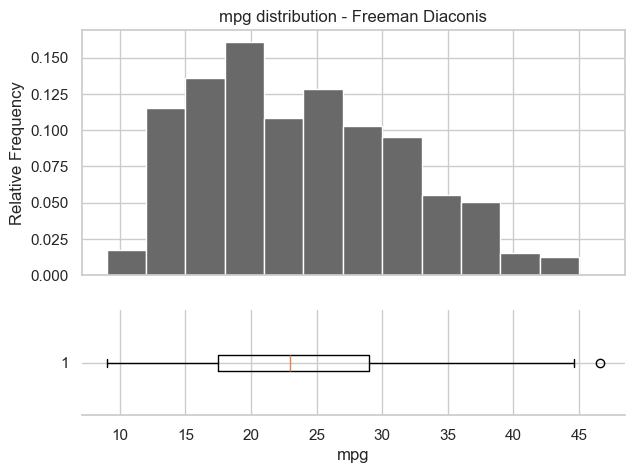

3

In [17]:
histogram_w_whiskers(data, 'mpg')

Looks like the tiniest bit of right skew, though otherwise symmetric as we predicted. We do see the max as an extreme value on the boxplot with whiskers, while it seems that most values are contained within the 'whiskers' (Q1 - 1.5 x IQR, Q3 + 1.5 x IQR). We can also try changing the bin size of the histogram to see if any patterns emerge, but I predict we won't see anything too unusual.

Freeman Diaconis for mpg: 13 bins


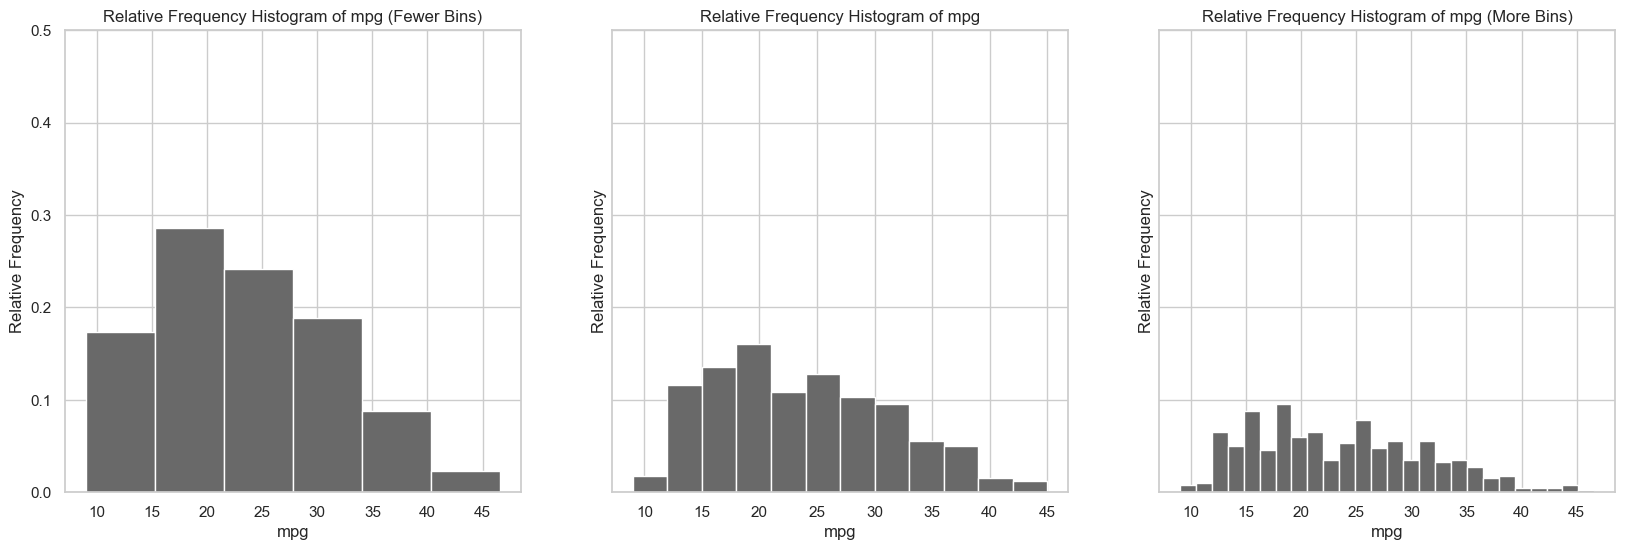

In [18]:
histogram_trio(data, 'mpg', zoom=0.5)

There seems to be a bit of a drop off as we go from about 12-13 down to 11 or so, which is a bit more evident with more bins. Other than that, we see almost a cyclic pattern with the more bins, which I wonder if it's simply because it is too many bins for this variable (remember that the range is not that large).

Since this is our target I won't spend too much time with takeaways here, but maybe there is another factor that explains the cyclic pattern in the histogram with more bins.

### <a id="cylinders">Cylinders</a>
<a href='#step2'> ^ EDA </a>

Now we look at cylinders. This represents how many cylinders the car's enginer has. This is also a numeric variable, though it is discrete, not continuous. I believe the most common cylinder types are 4 and 6, so I expect to see a large frequency of those values. As mentioned above, typically more cylinders leads to increased fuel usage and thus less efficient gas mileage. Here are the summary statistics:

In [19]:
data['cylinders'].describe()

count    398.000000
mean       5.454774
std        1.701004
min        3.000000
25%        4.000000
50%        4.000000
75%        8.000000
max        8.000000
Name: cylinders, dtype: float64

We see a mean of 5.45 and standard deviation of 1.7. The 3rd quartile and the max are both 8, while the 1st quartile and median are both 4. Let's look at the value counts to see how many different values for $cylinders$ we actually have.

In [20]:
data['cylinders'].value_counts().sort_index()

cylinders
3      4
4    204
5      3
6     84
8    103
Name: count, dtype: int64

The most common cylinder type is 4, while the second most is 8, by about half. 6 is not too far behind in third, and then only a few results for 3 and 5 cylinders.

Because this variable only has a few possibilities and is also a count variable, I'm going to treat this as an ordered categorical variable for charts (I don't think it makes sense for a histogram here, for example.) Apparently there are some cars that do have 3 and 5 cylinder engines, so we should still consider those valid entries.

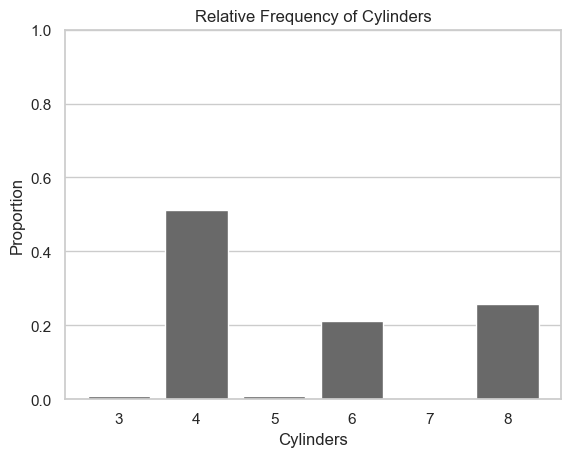

In [21]:
counts = data['cylinders'].value_counts().sort_index()
proportions = data['cylinders'].value_counts(normalize=True).sort_index()
x = sorted(data['cylinders'].unique())

plt.bar(x, proportions, color='dimgray')
plt.ylim((0, 1))
plt.grid(axis='x')

plt.xlabel('Cylinders')
plt.ylabel('Proportion')
plt.title('Relative Frequency of Cylinders')

plt.show()
plt.close()


Nothing unusual here - just a visualization of the value count results we found above. It is clear that 4 is the most common cylinder type, about half of the data consistents of 4 cylinder cars. 8 and 6 cylinders are a bit less common around 25 and 20 percent, respectively, and again only a few values for 3 and 5 cylinders.

1. More cylinders typically corresponds to higher power, so we suspect an increase in cylinders leads to an increase in horsepower

2. This horsepower increase leads to lower fuel mileage, so we might see similar patterns between $cylinders$ and $mpg$ as we do between $horsepower$ and $mpg$ for pairwise analysis

### <a id="displacement">Displacement</a>
<a href='#step2'> ^ EDA </a>

Next we have displacement, which is commonly used as an expression of an engine's size. It could also be indicative of power, though these days it's common for car manufacturer's to downsize engines and use powerboosters and other pieces to provide higher horsepower for a car's output.

[Engine Displacement](https://en.wikipedia.org/wiki/Engine_displacement) <br>
[What is Engine Displacement and Does it Matter?](https://www.capitalone.com/cars/learn/finding-the-right-car/what-is-engine-displacement-and-does-it-matter/2055)

From our domain knowledge, there is actually an equation to calculate displacement, which is dependent on cylinders:

$Displacement = stroke \ length * \pi (\frac{bore}{2})^2 * cylinders$

Where:
```
stroke length = cylinder height
bore = diameter of the hole drilled into engine block to accept a piston
cylinder = number of cylinders
```




$Displacement$ is a continuous numeric variable, so we can look at some summary statistics. We expect higher displacement values to correspond to higher horsepower and more fuel consumption, and this lower mileage.

In [22]:
data['displacement'].describe()

count    398.000000
mean     193.425879
std      104.269838
min       68.000000
25%      104.250000
50%      148.500000
75%      262.000000
max      455.000000
Name: displacement, dtype: float64

We see a mean of 193.4, but a median of only 148.5, indicating a right skew in the data. The standard deviation is large at 104.3. The min of 68 to the 1st quartile of 104.3 and 1st quartile to median are pretty evenly spaced. The median to 3rd quartile of 262 and 3rd quartile to max of 455 are not so much. We should expect to see a lot of large values in the histogram.

Freeman Diaconis for displacement: 9 bins


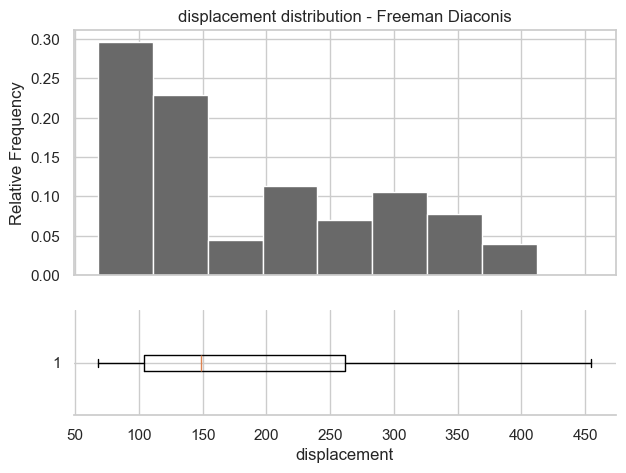

43

In [23]:
histogram_w_whiskers(data, 'displacement')

Because the interquartile range is so large, the boxplot does not show any extreme values. We do in fact see a strongly right skewed histogram, though the most common values seem to lie below the median. Let's try a histogram trio to see if changing bin size shows any interesting properties.

Freeman Diaconis for displacement: 9 bins


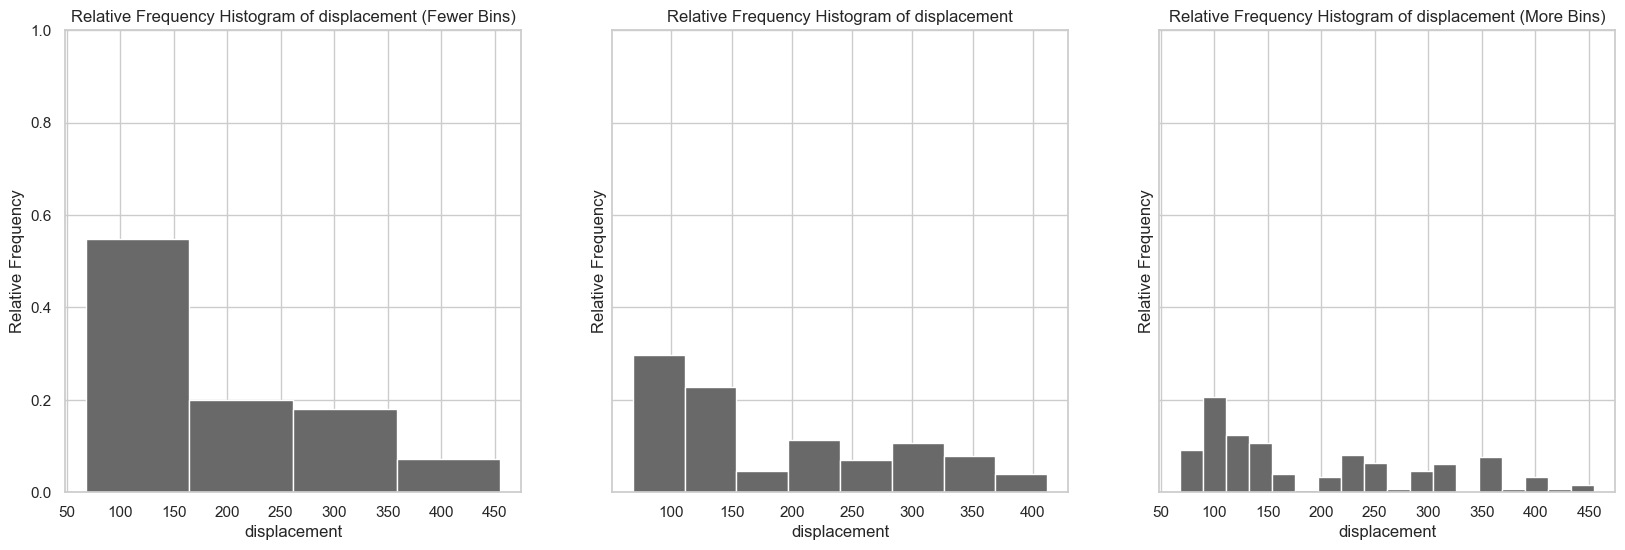

In [24]:
histogram_trio(data, 'displacement')

With more bins we see sort of a 'jumping' pattern - no values for certain ranges between some of the larger values, for example 250-300.

1. As mentioned, displacement is dependent on cylinders, which we know only have a few discrete values, so there are other factors to consider that we have no data for.

2. While this variable is continuous, we have to remember that auto makers likely have certain standards of quality control and tolerances for their manufacturing processes, so similar cars could have similar values of $displacement$.

### <a id="horsepower">Horsepower</a>
<a href='#step2'> ^ EDA </a>

Here we have horsepower, which basically describes how much rapidly a car's enginer can work / work output. According to this article:

[What is the Average Horsepower of a Car?](https://www.jdpower.com/cars/shopping-guides/what-is-the-average-horsepower-of-a-car)

The average horsepower for standard vehicles lies in the range of 180-200 horsepower. Whereas smaller cars might have closer to 100 horsepower, larger automobiles could see this as high as 300.

Like $displacement$, this is a continuous numeric variable, and so we can look at the summary statisticss. We expect most of the values to lie between 100-300, but apparently some engines can get up to 1,200 or so horsepower.

In [25]:
data['horsepower'].describe()

count    398.000000
mean     104.304020
std       38.222625
min       46.000000
25%       76.000000
50%       93.500000
75%      125.000000
max      230.000000
Name: horsepower, dtype: float64

The mean is 104 with a slightly lower median of 93.5 (which we knew from our ETL). The standard deviation is a good chunk of change at 38. The min is 46, and the max 230, a bit lower than we predicted. The 3rd quartile is only 125, so we might expect the max to be an extreme value for this dataset.

Let's look at a histogram and boxplot. We expect the histogram to show a right skew since median is less than the mean.

Freeman Diaconis for horsepower: 15 bins


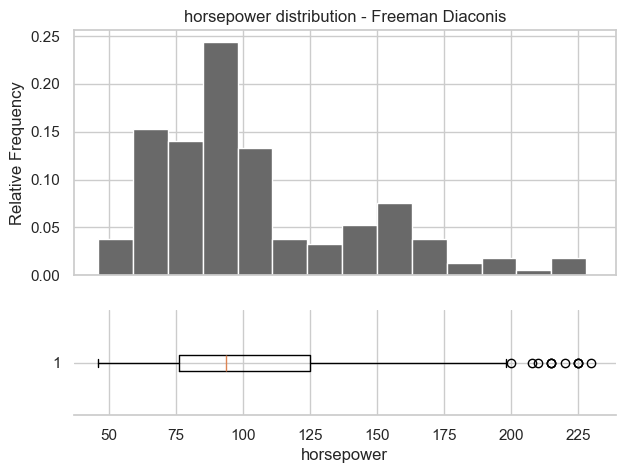

13

In [26]:
histogram_w_whiskers(data, 'horsepower')

We do see a right skewed histogram, with several extreme values between 200 and the max of 230. Let's also check different bin sizes of the histogram

Freeman Diaconis for horsepower: 15 bins


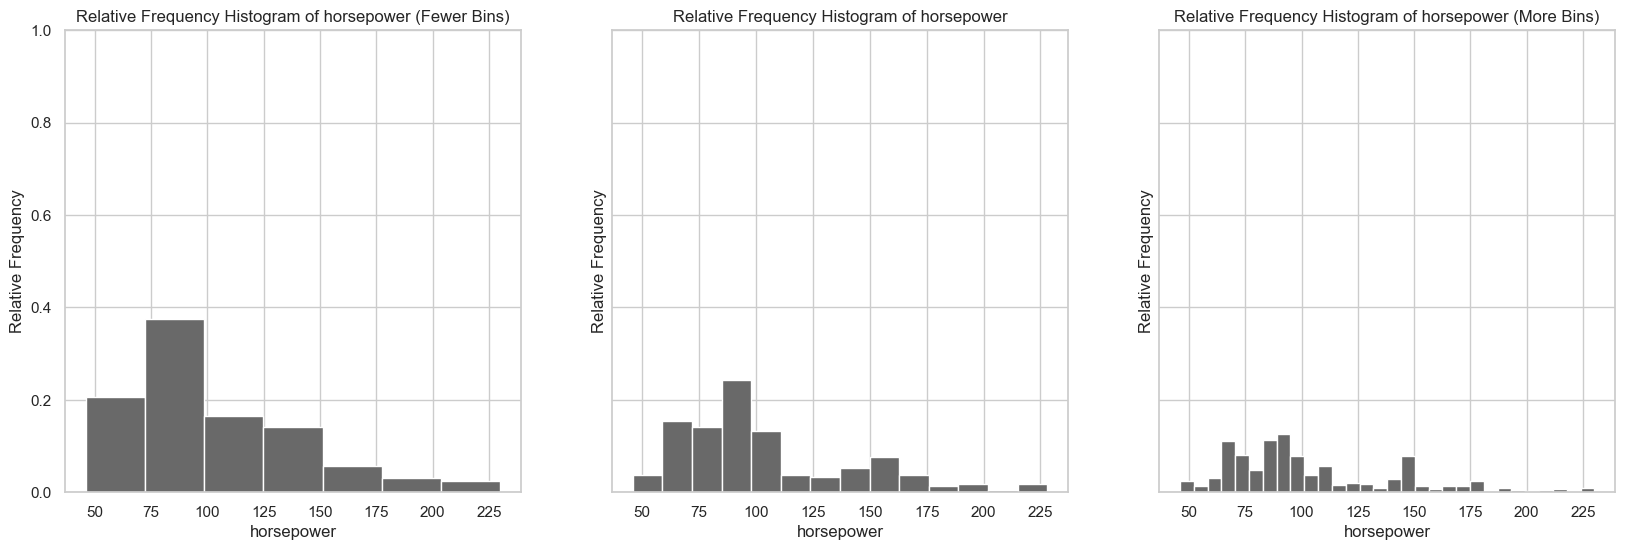

In [27]:
histogram_trio(data, 'horsepower')

I don't see any unusual patterns emerging here. There is a spike around 150, which could be worth looking it further. Overall though, I think each of these histograms tells the same story.

1. From our pseudo causal loop diagram, we expect $horsepower$ and $mpg$ to be negatively correlated.

2. $Horsepower$ and $cylinders$ are likely to be positively correlated. Both intend to increase fuel consumption and might lead to lower $mpg$.

### <a id="weight">Weight</a>
<a href='#step2'> ^ EDA </a>

Now we look at car weight. This is also a continuous, numeric variable. Typical car weight ranges are between 2,600 - 3,500 pounds - [how much does a car weigh?](https://www.insurancenavy.com/average-car-weight/) We expect larger cars to have bigger engines, and perhaps more cylinders. Since we already know the most common type of engine here is a 4-cylinder by a wide margin, I'd expect the weight distribution here to be closer to 2,600 than it is to 3,500. Let's see the summary statistics.

In [28]:
data['weight'].describe()

count     398.000000
mean     2970.424623
std       846.841774
min      1613.000000
25%      2223.750000
50%      2803.500000
75%      3608.000000
max      5140.000000
Name: weight, dtype: float64

We have a mean of 2970 and a median of about 2803, slightly smaller. The 1st quartile is 2223, close to the median, while the third quartile is slightly further away at 3608. The max is 5140, while the min is only 1613. For our histogram, we expect to see a a slight right skewed histogram, with possible extreme values above the 3rd quartile.

Freeman Diaconis for weight: 10 bins


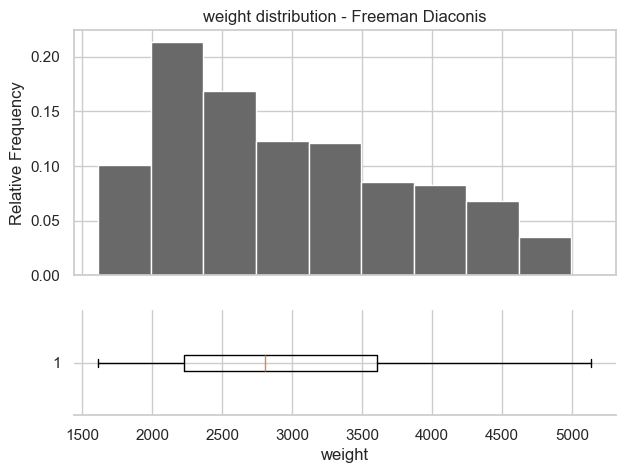

376

In [29]:
histogram_w_whiskers(data, 'weight')

Actually no extreme values, since the interquartile range of roughly 1,400 (and thus the 'whiskers') are fairly large to compensate. The most frequent weight is around 2,200, close to the 1st quartile, and the frequency steadily decreases as weight goes up from there. About 10% of the car weights are between the min (1613) and 2000. That seems interesting, since it doesn't fall into the same pattern.

Let's try changing bin sizes, maybe more bins can help clarify the low range of weights.

Freeman Diaconis for weight: 10 bins


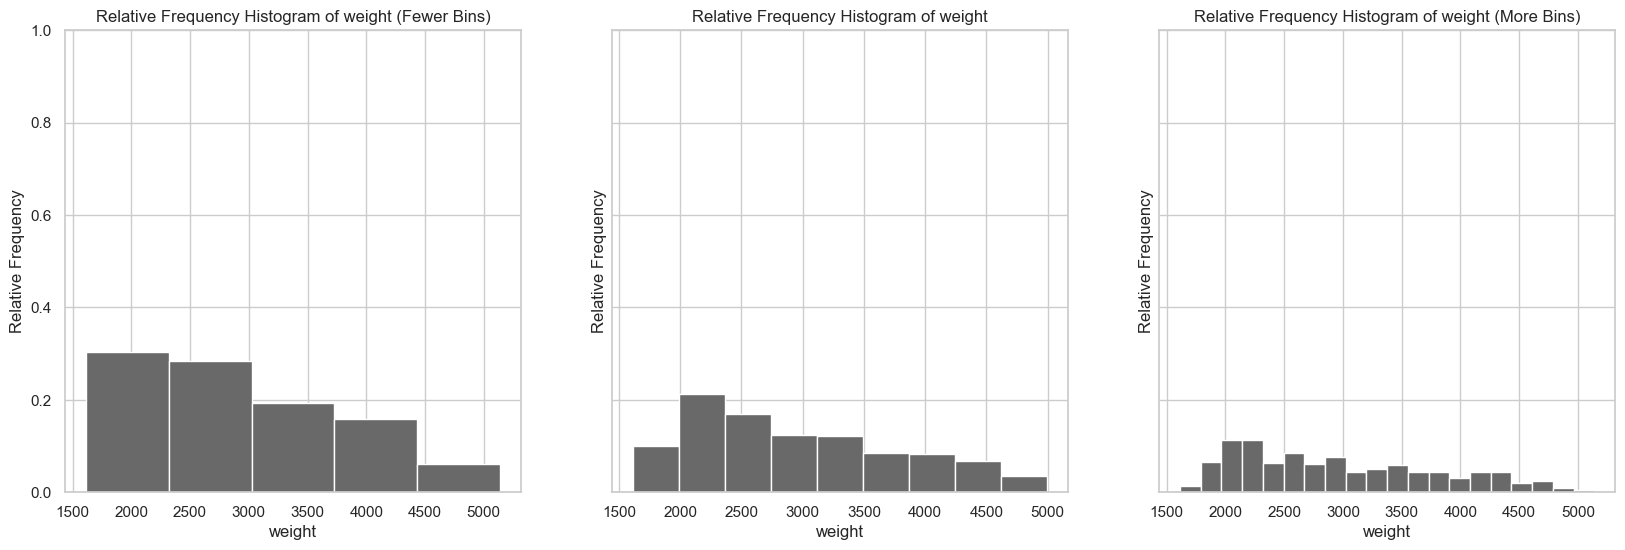

In [30]:
histogram_trio(data, 'weight')

Nothing too suspicious here, we see pretty much the same histogram as the initial plot. With less bins, we see the decreasing frquency pattern to include the lower weights, which looks nice but doesn't tell us much else unfortunately.

1. Cars that weigh more likely have bigger engines, use more $horsepower$, and thus could lead to lower $mpg$.

2. Again we expect auto makers to have certain quality control procedures, and could account for the decreasing proportion for larger weights, which might be for specialty vehicles.

3. It would be interesting to look at how some of the larger cars presented here compare to other types of vehicles such as schoolbuses and hospital vans.

### <a id="acceleration">Acceleration</a>
<a href='#step2'> ^ EDA </a>

Acceleration is the rate at which a car can increase its speed (or rate the speed decreases if we talk about deceleration). Acceleration is a standard physics equation given by:

$Acceleration = \frac{\Delta v}{\Delta t}$, where

$\Delta v = Change \ in \ velocity$ <br>
$\Delta t = Change \ in \ time$

I couldn't find a good source on typical values for car acceleration, but found that this measurement, at least in the US, is typically measured by how fast a car can accelerate from 0-60 miles per hour. According to [Wikipedia](https://en.wikipedia.org/wiki/List_of_fastest_production_cars_by_acceleration), some of the fastest cars can have an acceleration time of only about 2 seconds, while more typical values might be closer to 10 seconds. 

This is also a continuous numeric variable, so let's view the summary statistics. I'd expect the most frequent values to be close to 10, give or take a few seconds.

In [31]:
data['acceleration'].describe()

count    398.000000
mean      15.568090
std        2.757689
min        8.000000
25%       13.825000
50%       15.500000
75%       17.175000
max       24.800000
Name: acceleration, dtype: float64

We have a mean of 15.6 and standard deviation of 2.76. The min is 8 while the max is 24, not too large of a range. Our 1st quartile, median, and 3rd quartile are fairly tight at 13.8, 15.5, and 17.2, respectively. For our histogram, we expect a pretty symmetric plot, as our mean and median are nearly identical.

Freeman Diaconis for acceleration: 16 bins


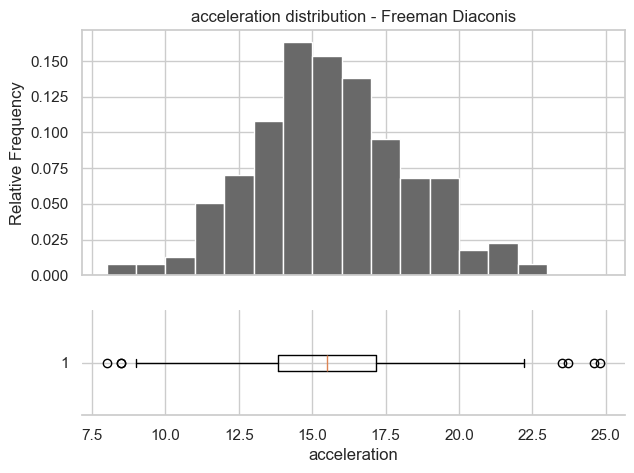

1

In [32]:
histogram_w_whiskers(data, 'acceleration')

We see a very symmetric histogram. There are a few extreme values on either side of the boxplot. Because we have such a small interquartile range, this is not unfounded. The values below about 11.0 and above 20.0 do show a dip on either side. Let's see if we can see any other interesting patterns by changing bin size.

Freeman Diaconis for acceleration: 16 bins


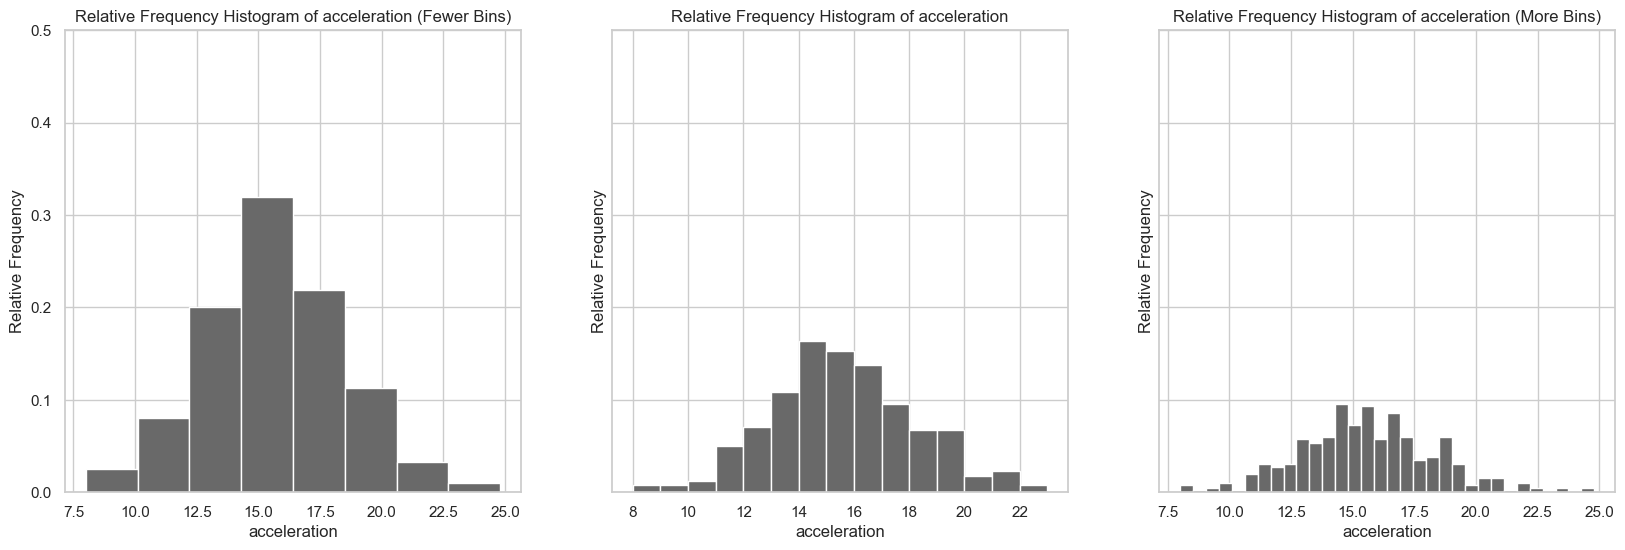

In [33]:
histogram_trio(data, 'acceleration', zoom=0.5)

Nothing too unusual here, this is just a simple, fairly symmetric histogram. 

1. Acceleration is not just dependent on the physics formula above, but we could consider $horsepower$ and maybe tire treads/friction as to how fast a car might accelerate - there are other unknown knowns and unknown unknowns that might play a role.

### <a id="year">Model Year</a>
<a href='#step2'> ^ EDA </a>

Let's look at $model \ year$. Similar to $cylinders$, this is a multi-valued, discrete variable. Although we will probably see a lot more variety in the values here than with $cylinders$. In general, I would expect cars made in later years to get better gas mileage, as technology has advanced steadily. Let's look at some summary statistics.

In [34]:
data['model year'].describe()

count    398.000000
mean      76.010050
std        3.697627
min       70.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       82.000000
Name: model year, dtype: float64

It looks like our mean is 76, same as the median. Min is 70, while the max is only 82. Clearly we are looking at the last 2 digits of year, and only cars between 1970 and 1982, so a 12 year span. The interquartile range is also fairly small because of this. Let's check the value counts to see how many values we have for each year.

In [35]:
data['model year'].value_counts().sort_index()

model year
70    29
71    28
72    28
73    40
74    27
75    30
76    34
77    28
78    36
79    29
80    29
81    29
82    31
Name: count, dtype: int64

A fairly even distribution over the range of $model \ year$. Most years have around 30 counts in this data set. We might consider applying the same principles here as we did with $cylinders$, where we considered it an ordered categorical variable. Because there are several more values here, I will simply move forward with the traditional histogram with whiskers and trio of histograms we look for with numerical variables.

Freeman Diaconis for model year: 12 bins


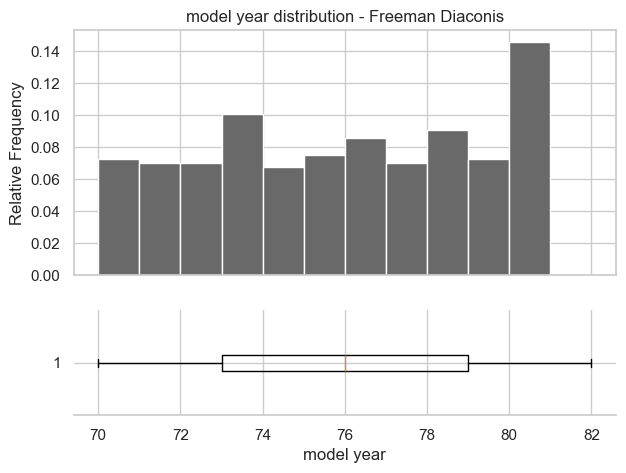

1

In [36]:
histogram_w_whiskers(data, 'model year')

We expected to see a slightly larger hump for 73, but not at 81. Notice that we have 13 discrete values for $model \ year$, but only 11 bins in this histogram. Likely, the last few values are being crunched together. Let's look at the trio of histograms to see if we can placate this abnormality. We also don't see any extreme values from the boxplot.

Freeman Diaconis for model year: 12 bins


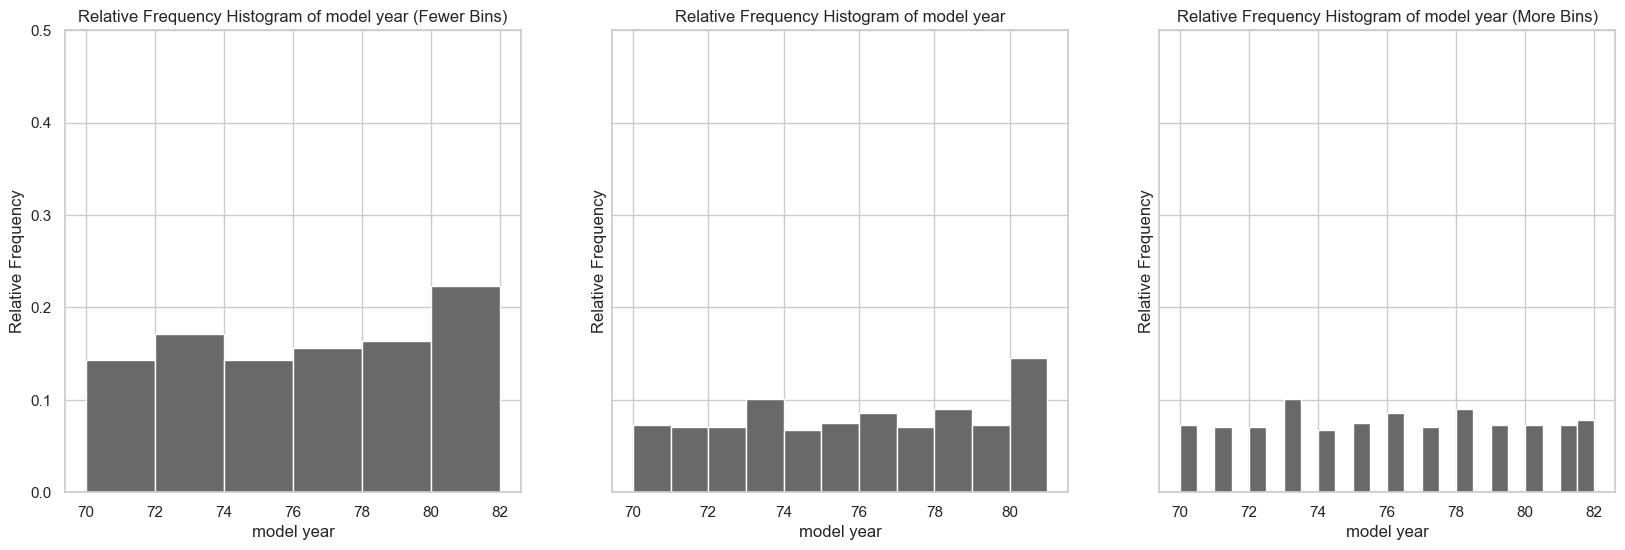

In [37]:
histogram_trio(data, 'model year', zoom=0.5)

The histogram with more bins helps I think. We know from looking at value counts that the years 79, 80, and 81 all have the same count (and thus the same relative frequency), while counts for 82 are barely higher - this is what we see in the histogram with more bins. The histograms with fewer bins are masking this a bit, which could lead to some confusion. That's why it's important we look at both the data and the plots here. In this case, it's important we choose the right bin size for our histogram.

1. Data for this dataset may have been chosen to represent a relatively even distribution of model years. If we had more time, I think it would be interesting to do pairwise analysis between $model \ year$ and some other variables, but I will stick with just the target variable for now.

2. We are only looking at a small range of years in this dataset, so we might not expect to see EDA analysis here that is consistent with newer cars in current decade.

### <a id="origin">Origin</a>
<a href='#step2'> ^ EDA </a>

Next we have $origin$, and rightfully so. This is a multi-valued discrete variable, similar to what we just saw. We can start with some summary statistics to describe the values we have in this dataset.

In [38]:
data['origin'].describe()

count    398.000000
mean       1.572864
std        0.802055
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: origin, dtype: float64

Okay, so we have a mean of 1.57, and standard deviation of 0.8. What's interesting is that the min, 1st quartile, and median are all 1. The 3rd quartile is only 2, while max is 3. So essentially we only have 3 values here - 1, 2, or 3. We can confirm this with value counts.

In [39]:
data['origin'].value_counts().sort_index()

origin
1    249
2     70
3     79
Name: count, dtype: int64

Now what does 1, 2, or 3 actually mean? We know that cars can typically be described by manufacturer's country of origin (such as Toyota is a Japanese company), so it's likely that this variable is encoded as numeric, but should really be classified as categorical. I can't find online which countries these values actually represent (I know this set comes from Statlib, but can't seem to find the original), so we will just work with what we have. It seems that 1 might be America, 2 Europe, and 3 Asia, but since I don't have concrete evidence of this, I will work with 1, 2, and 3 for now.

We can treat this as a categorical variable, it shouldn't really be ordered as country of origin does not have an order unlike what we saw for $cylinders$. We see most of the cars come from country 1, while there's a pretty even split between countries 2 and 3. I think a bar chart will be suffcient for now, as we shouldn't expect to see anything super interesting or unexpected.

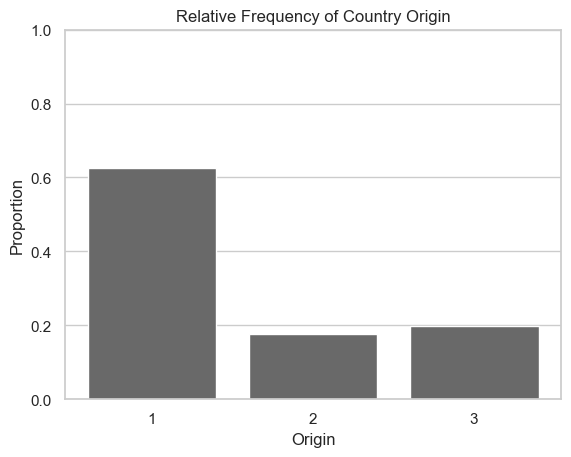

In [40]:
counts = data['origin'].value_counts().sort_index()
proportions = data['origin'].value_counts(normalize=True).sort_index()
x = sorted(data['origin'].unique())

plt.bar(x, proportions, color='dimgray')
plt.ylim((0, 1))
plt.grid(axis='x')
plt.xticks(x)

plt.xlabel('Origin')
plt.ylabel('Proportion')
plt.title('Relative Frequency of Country Origin')

plt.show()
plt.close()

A little over 60% of the cars come from country 1, while slightly less than 20% are from countries 2 and 3. Again, nothing with what the value counts didn't tell us.

1. This dataset presents as being US-centric with $origin$ and $acceleration$ appearing to be based on US standards.

2. Several more regions might help discretize this variable further, so we might be inclined to do more research on the origin of $origin$.

### <a id="name">Car Name</a>
<a href='#step2'> ^ EDA </a>

Finally we arrive at $car \ name$. This is a string/cateogrical variable ('object' in Python), and we know from our `auto_mpg_names` file that each value is unique, meaning we have 398 unique values here.

In [41]:
len(data['car name'].unique())

305

Or not. It looks like we only have 305 unique values out of 398. To me, 'unique for each instance' would mean each value for $car \ name$ is unique, but I guess that's not the case here. It should be unordered since there is not order to a car name. Let's look at the top value counts to get an idea of the most popular car names in the dataset.

In [42]:
data['car name'].value_counts()

car name
ford pinto             6
toyota corolla         5
amc matador            5
ford maverick          5
chevrolet chevette     4
                      ..
chevrolet monza 2+2    1
ford mustang ii        1
pontiac astro          1
amc pacer              1
chevy s-10             1
Name: count, Length: 305, dtype: int64

We see ford pinto has 6 values, while the next highest is tied between toyota corolla, amc matador, and ford maverick at 5. We can also check how many of these names are truly unique.

In [43]:
counts = data['car name'].value_counts()
len(counts[counts == 1])

249

So we have 249 instances where the $car \ name$ is the only one of its kind in the dataset. The last thing we might be interested in looking at is how many of each count value appear in the dataset.

In [44]:
counts.value_counts()

count
1    249
2     34
3     12
4      6
5      3
6      1
Name: count, dtype: int64

So most $car \ names$ are in fact unique, with only a small portion having 2 or more values of the exact same name. Finally I will create a bar chart of these value counts so we can get an idea of how common a car name is - I don't think I can actually plot separate car names on the same chart as 305 values would be too messy.

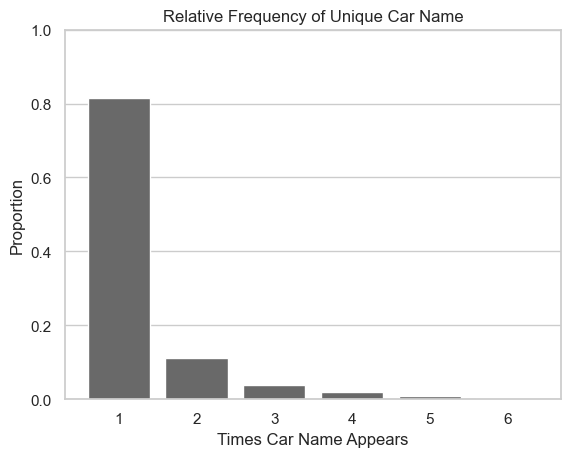

In [45]:
counts = data['car name'].value_counts()
proportions = counts.value_counts(normalize=True)
x = sorted(counts.unique())

plt.bar(x, proportions, color='dimgray')
plt.ylim((0, 1))
plt.grid(axis='x')
plt.xticks(x)

plt.xlabel('Times Car Name Appears')
plt.ylabel('Proportion')
plt.title('Relative Frequency of Unique Car Name')

plt.show()
plt.close()

We see about 80% of the data has a unique car name. Nothing too interesting or unusual here. I think it's time to move on to pairwise EDA analysis.

1. Some car names are similar, such as 'toyota corona' and 'toyota corona hardtop'. It might make sense to combine some of these in a single non-unique name.

2. The car brand name is important to a lot of people. This might influence how manufacturer's choose to improve their newer models ('Can we get away with substituting a less powerful engine if everyone wants a Ferrari?')

## Pairwise EDA with Target Variable (MPG)

### <a id="mpg_cylinders">MPG vs Cylinders</a> <br>
<a href='#step2'> ^ EDA </a>

Since $mpg$ is our target variable, I will focus the discussion of pairwise analysis on $mpg$ with our other variables. Let's first look at $cylinders$. As theorized, as $cylinders$ increases from 4 to 6 to 8, I'd expect the fuel consumption to increase, and thus the $mpg$ of the car to decrease.

Since these are both numeric variables, we can look at both the Pearson and Spearman correlation coefficient to get an idea of how linearly related the variables are, and the monotonicity of the relationship, respectively.

In [46]:
print('r = ', stats.pearsonr(data['cylinders'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['cylinders'], data['mpg'])[0])

r =  -0.7753962854205543
rho =  -0.8218644914450967


We do in fact see strong negative correlations here, as predicted. Pearson's r is -0.78, so as number of $cylinders$ increases, we would expect $mpg$ to linearly decrease as a result. Spearman's rho is a -0.82 so we expect a strong monotonic decreasing relationship.

Let's look at a scatter plot to get a visual idea of this relationship.

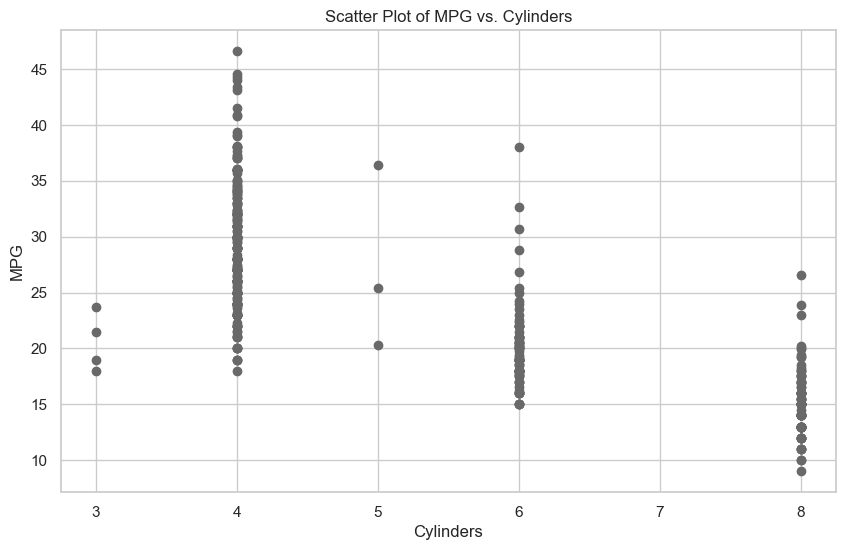

In [47]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['cylinders'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Cylinders')
axes.set_title("Scatter Plot of MPG vs. Cylinders")

plt.show()
plt.close()

Hmm not the best plot. Because we only have a few discrete values for $cylinders$, I will go back and treat it again as an ordered categorical variable. In this case, it would be more interesting to look at multiple boxplots. Note I am using some functions from the `eda.py` file.

In [48]:
import eda

C:\Users\Jhirs\AppData\Local\Temp\ipykernel_16700\953294986.py:5: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels = pd.unique(sorted(data['cylinders'].values))


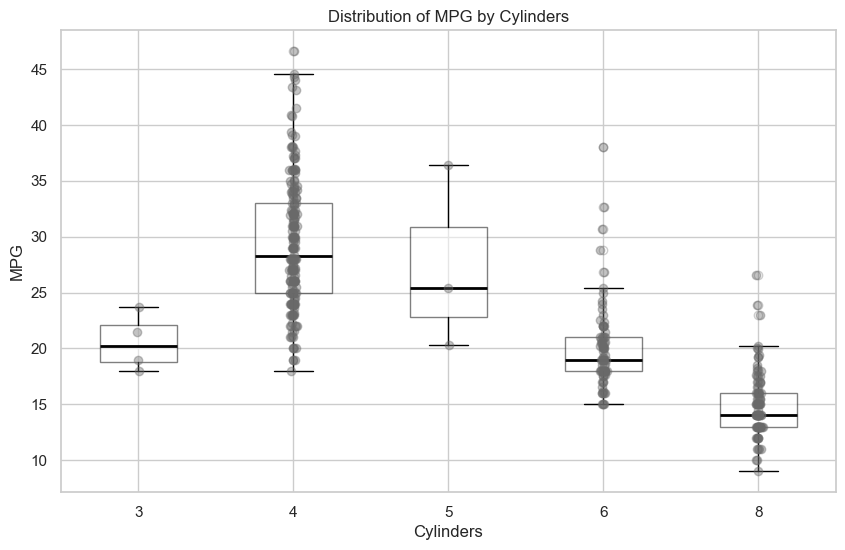

In [49]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

labels = pd.unique(sorted(data['cylinders'].values))
grouped = data.groupby('cylinders')
grouped_data = [grouped['mpg'].get_group(k) for k in labels]
patch = axes.boxplot(grouped_data, labels=labels, patch_artist=True, zorder=1)
eda.restyle_boxplot(patch)

for i,k in enumerate(labels):
    subdata = grouped['mpg'].get_group(k)
    x = np.random.normal(i+1, 0.01, size=len(subdata))
    axes.plot(x, subdata, 'o', alpha=0.4, color='dimgray', zorder=2)

axes.set_ylabel('MPG')
axes.set_xlabel('Cylinders')
axes.set_title('Distribution of MPG by Cylinders')

plt.show()
plt.close()

So we see $mpg$ go up a bit as we increase from 3 to 4 cylinder cars. We decrease $mpg$ slightly at 5 cylinders, and then much more sharply at 6 and then 8 cylinder cars. We notice the 6 cylinder and 8 cylinder boxplots also have smaller interquartile ranges and relatively more extreme values then those cars with 4 cylinders.

There's a bit of an overlap between 3 and 6 cylinders, as well as the distributions for 4 and 5 cylinders.

### <a id="mpg_displacement">MPG vs Displacement</a> <br>
<a href='#step2'> ^ EDA </a>

Now let's look at how $displacement$ might affect $mpg$. Again, $displacement$ is often representative of engine size, and the equation we saw from our single variable EDA showed that it relies on number of cylinders. As such, we could predict that $displacement$ will have the same kind of correlation to $mpg$ that we saw for $cylinders$ and $mpg$ - strongly negatively correlated. Let's look at the correlation coefficients.

In [50]:
print('r = ', stats.pearsonr(data['displacement'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['displacement'], data['mpg'])[0])

r =  -0.804202824805898
rho =  -0.8556920118178749


It looks like our predictions are spot on. Again we have a strong negative Pearson's r of -0.80, and a strong negative Spearman's rho of -0.86. Not too surprising since we know $displacment$ and $cylinders$ are directly related.

Since $displacement$ is a continuous numeric variable, I think a scatter plot here would be best to visualize this relationship.

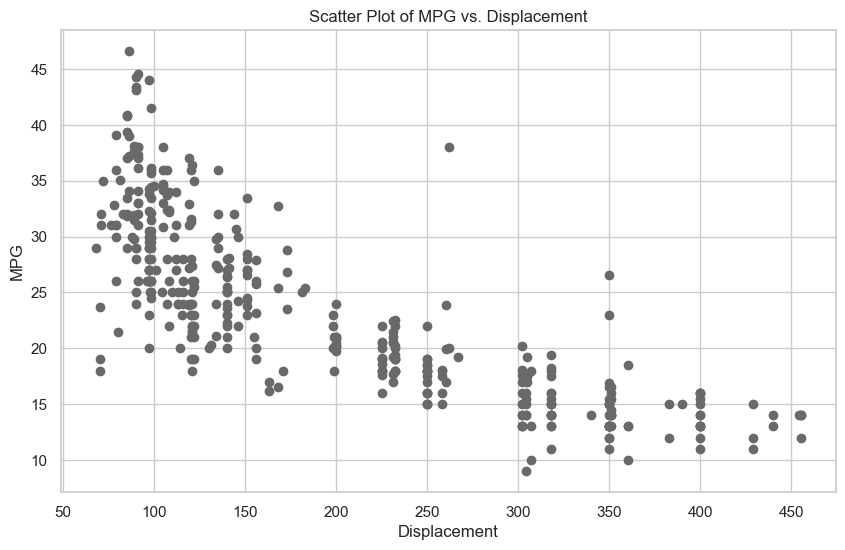

In [51]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['displacement'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Displacement')
axes.set_title("Scatter Plot of MPG vs. Displacement")

plt.show()
plt.close()

We do in fact see a linear decreasing relationship between $mpg$ and $displacement$ - not perfect mind you, but good enough for our purposes. There seems to be one extreme value at a $displacement$ of about 260, where the $mpg$ is much higher, around 38 or so. There are also a few higher values for $mpg$ when $displacement$ is around 350. 

### <a id="mpg_horsepower">MPG vs Horsepower</a> <br>
<a href='#step2'> ^ EDA </a>

Now let's take a look at how $horsepower$ might affect $mpg$. We already know $horsepower$ is a continuous numeric variable, so I predict we will see similar results as $displacement$ - more $horsepower$ leads to lower $mpg$. Let's see the correlation coefficients.

In [52]:
print('r = ', stats.pearsonr(data['horsepower'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['horsepower'], data['mpg'])[0])

r =  -0.7734532045742155
rho =  -0.8479748547388403


Again we see a strong negative correlation between these two variables, with a Pearson's r of -0.77 and Spearman's rho of -0.85. This is what we'd expect, since we already saw higher number of $cylinders$ leads to lower $mpg$, and typically higher $cylinders$ also corresponds to higher $horsepower$. Let's look at a scatter plot.

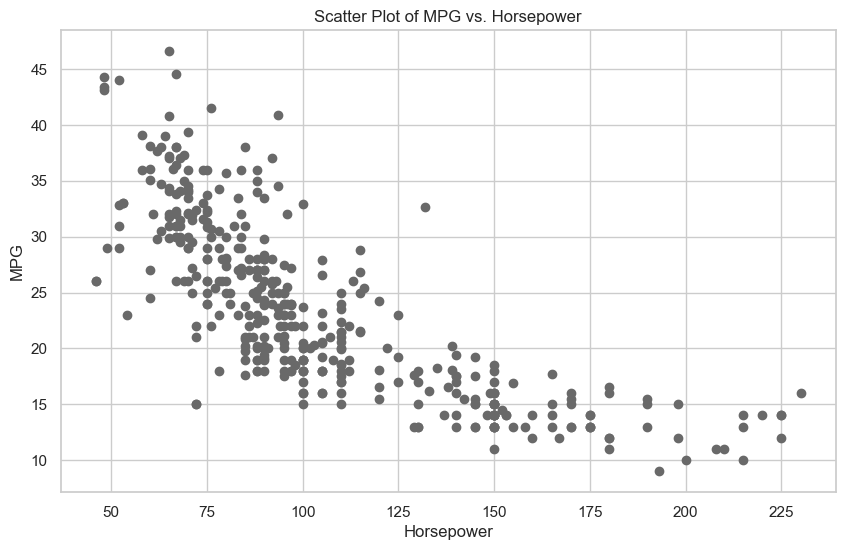

In [53]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['horsepower'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Horsepower')
axes.set_title("Scatter Plot of MPG vs. Horsepower")

plt.show()
plt.close()

A very similar scatter plot to what we saw with $mpg$ and $displacement$. We could imagine how a regression line could be fit here, but that's getting ahead of ourselves, and we shouldn't put the cart before the $horsepower$.

1. So far all our features are negatively correlated with $mpg$. Do we have any variables that are positively correlated here?

2. We had a slight spike at 150 $horsepower$ in our single variable EDA. It doesn't look like there are any extreme values related to $mpg$ there, but we might be interested in looking further at the value of 130 $horsepower$ and about 33 $mpg$.

### <a id="mpg_weight">MPG vs Weight</a> <br>
<a href='#step2'> ^ EDA </a>

Let's move on to $mpg$ vs $weight$. Remember that $weight$ is also a continuous numeric variable. There was a steadily decreasing proportion of cars with higher weights as we saw in single variable EDA. I think we'll continue to see the same pattern here when compared to $mpg$ - as we increase $weight$, you'd probably need a larger engine/higher $displacement$, and thus lower $mpg$. Here are the correlation coefficients.

In [54]:
print('r = ', stats.pearsonr(data['weight'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['weight'], data['mpg'])[0])

r =  -0.831740933244335
rho =  -0.8749473981990712


Very strongly negatively correlated, with -0.83 and -0.87 for Pearson's r and Spearman's rho, respectively. I think a scatterplot will show a similar plot to what we saw with $mpg$ and $displacement$ as well. This is the strongest correlation we've seen yet, though not by too much.

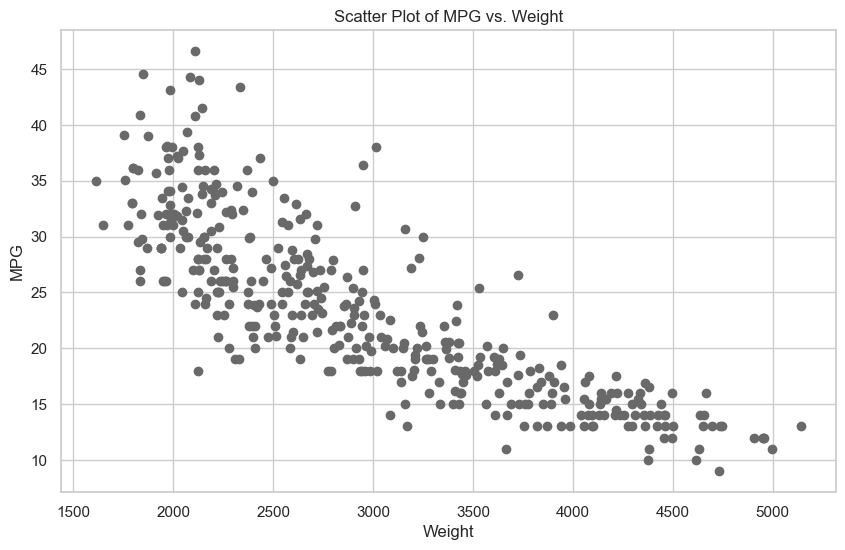

In [55]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['weight'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Weight')
axes.set_title("Scatter Plot of MPG vs. Weight")

plt.show()
plt.close()

Steadily decreasing, no surprise there. We see some more variability at the lower weights than we do for the higher weights. We saw from single variable EDA that weights around 2000 were the most frequent, and weights below 2000 dropped off a bit. The highest $mpg$ cars have weights close to 2100-2200.

### <a id="mpg_acceleration">MPG vs Acceleration</a> <br>
<a href='#step2'> ^ EDA </a>

Now we can look at how $acceleration$ relates to $mpg$. In general, accelerating a car uses more fuel, so I predict higher values of $acceleration$ will lead to lower $mpg$, although I don't think it will be as strongly correlated as say $mpg$ and $weight$.

In [56]:
print('r = ', stats.pearsonr(data['acceleration'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['acceleration'], data['mpg'])[0])

r =  0.42028891210165065
rho =  0.4386774795708622


We actually see a weak positive correlation here, with Pearson's r of 0.42 and Spearman's rho of 0.44. According to the [EPA](https://www.fueleconomy.gov/feg/factors.shtml#:~:text=Aggressive%20driving%20(speeding%2C%20rapid%20acceleration,more%20idling%20will%20lower%20MPG)), aggressive acceleration and deceleration actually decreases gas mileage by a sizeable chunk, around 15-30% at highway speeds. We can take a look at the scatter plot to visualize this relationship as well.

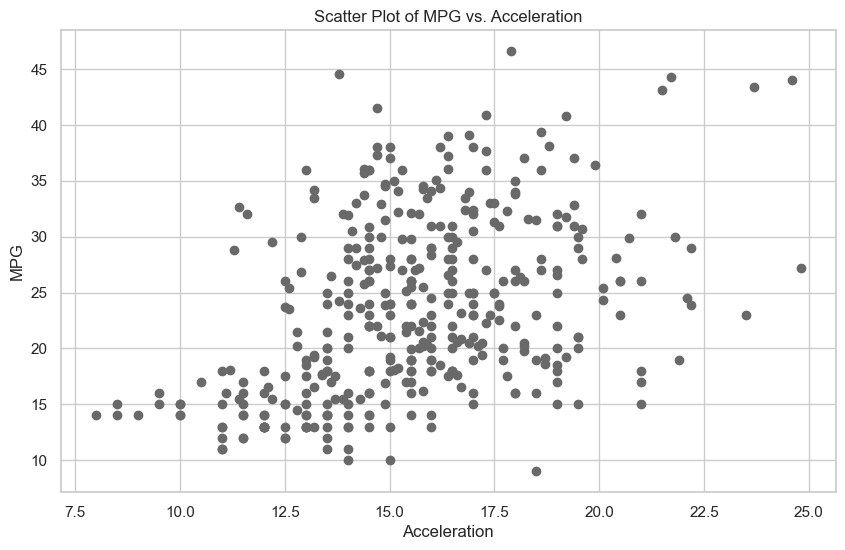

In [57]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['acceleration'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Acceleration')
axes.set_title("Scatter Plot of MPG vs. Acceleration")

plt.show()
plt.close()

We definitely don't see a strong linear relationship here. I mean we are seeing that lower $acceleration$ around 7.5-10.0 typically leads to lower $mpg$ around 15, and vice versa for higher values of $acceleration$, but we have some more extreme values here as well.

1. It's interesting that the highest values of $acceleration$ jump between about 22-27 $mpg$ and then up to 43-44 $mpg$, some of the highest gas mileage.

2. I'd be curious to know exactly how $acceleration$ was measured, did every car use the same road, the same weather conditions, etc.

### <a id="mpg_year">MPG vs Model Year</a> <br>
<a href='#step2'> ^ EDA </a>

Model year is a multi-valued discrete variable with only 13 values between 70-82. Newer cars typically have better gas mileage, as technology has moved foward over the years. I predict we will see cars made more recently will have a higher $mpg$ value, but the correlation will be fairly weak since we don't have a large range of years. We can look at the correlation coefficients first.

In [58]:
print('r = ', stats.pearsonr(data['model year'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['model year'], data['mpg'])[0])

r =  0.5792671330833096
rho =  0.5734687031921751


We do see a fairly strong correlation between $model year$ and $mpg$. Not as strong as some other variables we've looked at, but definitely enough to be interesting. Let's see a scatter plot, though I think we may also need a boxplot, similar to how we looked at $cylinders$ vs $mpg$.

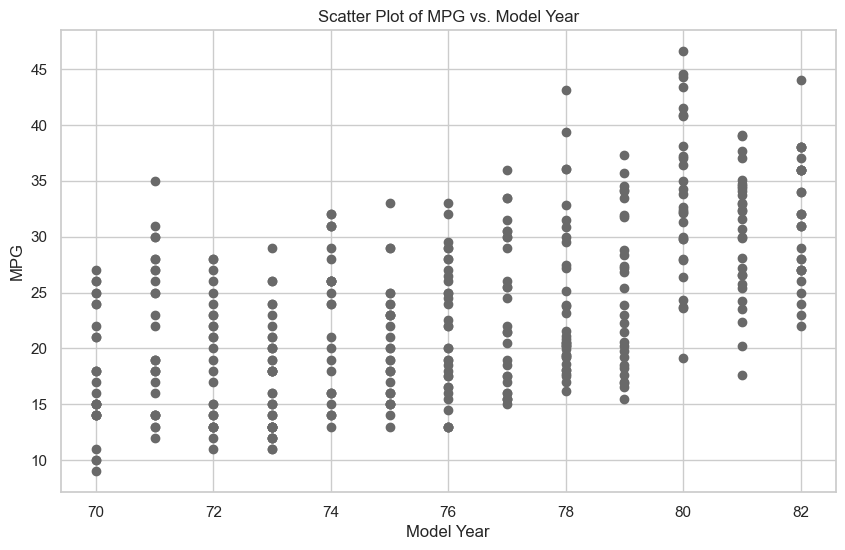

In [59]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['model year'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Model Year')
axes.set_title("Scatter Plot of MPG vs. Model Year")

plt.show()
plt.close()

We do see a pattern here, as the cars closer to $model \ year$ of 80-82 have higher values of $mpg$ than for cars made between 70-72. I think a boxplot would be more appropriate here, so let's try that as well.

C:\Users\Jhirs\AppData\Local\Temp\ipykernel_16700\105776740.py:5: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels = pd.unique(sorted(data['model year'].values))


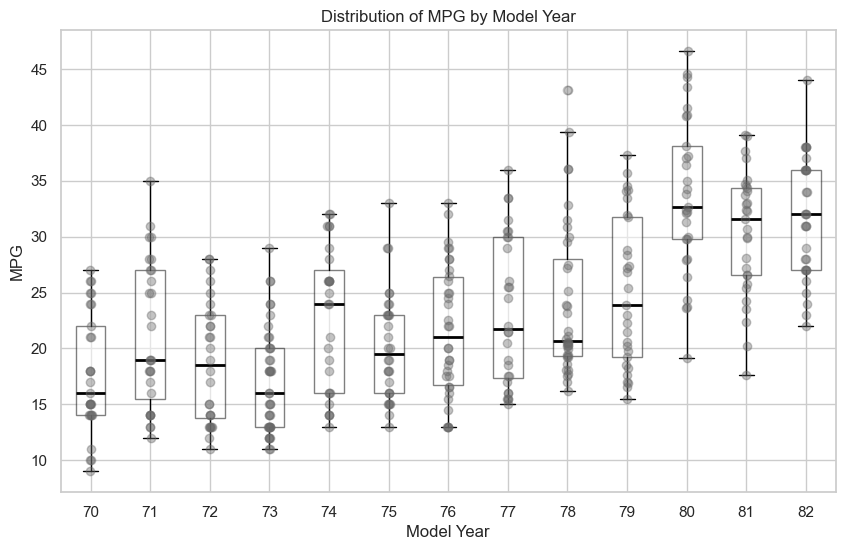

In [60]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

labels = pd.unique(sorted(data['model year'].values))
grouped = data.groupby('model year')
grouped_data = [grouped['mpg'].get_group(k) for k in labels]
patch = axes.boxplot(grouped_data, labels=labels, patch_artist=True, zorder=1)
eda.restyle_boxplot(patch)

for i,k in enumerate(labels):
    subdata = grouped['mpg'].get_group(k)
    x = np.random.normal(i+1, 0.01, size=len(subdata))
    axes.plot(x, subdata, 'o', alpha=0.4, color='dimgray', zorder=2)

axes.set_ylabel('MPG')
axes.set_xlabel('Model Year')
axes.set_title('Distribution of MPG by Model Year')

plt.show()
plt.close()

Not the cleanest plot, but we can see that the median $mpg$ steadily increases from 75 onward. There was a jump at 74, but also a much larger interquartile range, so that may be worth looking at further. The jump from 79 to 80 was fairly large, but then stagnates between 80-82 which is interesting.

1. What happened between 79 and 80 for such a big jump in $mpg$?

2. Why is the median $mpg$ for 74 much higher than in 73 and 75?

These both are interesting questions that could be worth looking into.

### <a id="mpg_origin">MPG vs Origin</a> <br>
<a href='#step2'> ^ EDA </a>

Now let's look at how $origin$ might affect $mpg$. Remember we only have 3 values for $origin$ 1, 2, and 3, which I believe to be America, Europe, and Asia respectively. According to [ResearchGate](https://www.researchgate.net/figure/Comparison-of-Fuel-Economy-Standards-across-Countries_fig1_23723548#:~:text=By%20and%20large%2C%20Japan%20has,European%20Union%20(figure%202)%20), cars made in Japan have the best fuel economy, while America boasts some of the lowest. If that's the case, we should see cars labeled as 1 having lower $mpg$ than cars labeled as 3 or maybe 2 as well. We can start with correlation coefficients.

In [61]:
print('r = ', stats.pearsonr(data['origin'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['origin'], data['mpg'])[0])

r =  0.5634503597738432
rho =  0.5806936941648105


Similar to $model \ year$, we see a fairly strong positive correlation with a Pearson's r of 0.56 and Spearman's rho of 0.58. I don't think a scatter plot will be of use since we have only 3 values for $origin$, so instead I will try small multiples so we can get a histogram of $mpg$ by $origin$. I also think densities will be much more interesting to look at than raw counts.

C:\Users\Jhirs\AppData\Local\Temp\ipykernel_16700\3710663492.py:4: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels = pd.unique(sorted(data['origin'].values))


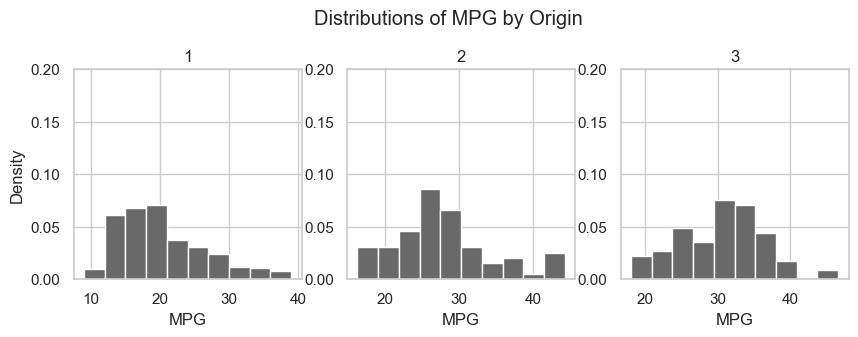

In [62]:
figure = plt.figure(figsize=(10,6))
figure.suptitle('Distributions of MPG by Origin')

labels = pd.unique(sorted(data['origin'].values))
grouped = data.groupby('origin')
grouped_data = [grouped['mpg'].get_group(k) for k in labels]

for i, x in enumerate(labels):
    axes = figure.add_subplot(2,3, i+1)
    subdata = grouped['mpg'].get_group(x).values
    axes.hist(subdata, color='dimgray', density=True)
    axes.set_title(x)
    axes.set_ylim((0,0.2))
    
    axes.set_xlabel('MPG')
    if (i % 3 == 0):
        axes.set_ylabel('Density')

plt.show()
plt.close()

Cars made in country 3 have $mpg$ values centered around 30 mpg, while cars from country 2 are a bit lower around 28 mpg or so. Cars from country 1 have the lowest fuel economy as predicted, centered closer to 20 mpg. We see that cars made in country 3 do on average have higher $mpg$ values than cars from country 1, and slightly better fuel economy than cars from country 2 as well.

1. In each histogram, there's a very small percentage, if any, of cars with $mpg$ around 40, but then an increase for cars with $mpg$ closer to 45. This is an interesting pattern but I'm not sure why this is the case.

### <a id="mpg_name">MPG vs Car Name</a> <br>
<a href='#step2'> ^ EDA </a>

Finally we have $mpg$ against $car \ name$. Remember that we have 305 unique values for $car \ name$ out of our 398 observations in the dataset. Since $car \ name$ is a categorical (string) variable, we can't use our usual correlation coefficients here.

Honestly it would be too difficult to do an EDA analysis for $car \ name$ because there are so many values. There is one thing I can try. It seems that the first word for most car names is the company brand, such as 'ford' or 'toyota'. I can try to group similar values by car company name by taking the first word in each value of $car \ name$ to consolidate some values. Let's try it.

In [63]:
data['brand'] = data['car name'].apply(lambda x: x.split()[0])
print(data['brand'].unique())
print('Unique Car Brands: ', len(data['brand'].unique()))

['chevrolet' 'buick' 'plymouth' 'amc' 'ford' 'pontiac' 'dodge' 'toyota'
 'datsun' 'volkswagen' 'peugeot' 'audi' 'saab' 'bmw' 'chevy' 'hi'
 'mercury' 'opel' 'fiat' 'oldsmobile' 'chrysler' 'mazda' 'volvo' 'renault'
 'toyouta' 'maxda' 'honda' 'subaru' 'chevroelt' 'capri' 'vw'
 'mercedes-benz' 'cadillac' 'mercedes' 'vokswagen' 'triumph' 'nissan']
Unique Car Brands:  37


So now we have 37 values of car brands instead of the 305 for $car \ name$. I believe this is still too many values to really get a good insight to how $car \ name$ and $mpg$ are related. One obvious thing to note is that there are some very clear typos in some of these names - such as 'toyouta' instead of 'toyota', 'chevroelt' instead of 'chevrolet', and 'vokswagen' instead of 'volkswagen'. This is really all I can do for the $car \ name$ variable, but we will press on with the belief that $car \ name$ does not influence $mpg$ to a high degree, at least relative compared to some other variables we've already looked at such as $weight$ and $horsepower$.

I could go back to ETL and correct the $car \ name$ variable to free it from these typos, but again I don't think it's worth the time here, as there are much more interesting variables to look at.

### $Summary$

#### $Dealing \ with \ Extreme \ Values - Displacement$

When we looked at how $displacement$ could affect $mpg$, we saw an extreme value somewhere between 250-300 for $displacement$, where the $mpg$ was much higher then cars of similar $displacement$. I'm going to investigate why that might be the case here briefly. Let's grab that observation.

In [64]:
data[(250 < data['displacement']) & (data['displacement'] < 275) & (35 < data['mpg'])]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,brand
387,38.0,6,262.0,85.0,3015.0,17.0,82,1,oldsmobile cutlass ciera (diesel),oldsmobile


We see that this is an oldsmobile, with an $mpg$ of 38.0. We can compare it to other cars of similar type, maybe by looking at other oldsmobiles.

In [65]:
oldsmobile = pd.DataFrame(data[data['brand'] == 'oldsmobile'])
oldsmobile = oldsmobile.sort_values(by='mpg', ascending=False)
oldsmobile.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,brand
387,38.0,6,262.0,85.0,3015.0,17.0,82,1,oldsmobile cutlass ciera (diesel),oldsmobile
307,26.8,6,173.0,115.0,2700.0,12.9,79,1,oldsmobile omega brougham,oldsmobile
364,26.6,8,350.0,105.0,3725.0,19.0,81,1,oldsmobile cutlass ls,oldsmobile
300,23.9,8,260.0,90.0,3420.0,22.2,79,1,oldsmobile cutlass salon brougham,oldsmobile
272,23.8,4,151.0,85.0,2855.0,17.6,78,1,oldsmobile starfire sx,oldsmobile


Here we have all the cars labeled as oldsmobiles, sorted by $mpg$ in descending order. We see the extreme value where we have a $displacement$ of 262.0 and $mpg$ of 38.0, while the next best oldsmobile for fuel economy only has a $displacement$ of 173.0, but is down to $mpg$ of 26.8.

The top value also has the latest possible $model \ year$ in 82, while the other cars were made in earlier years. Looking at some of the other features, the top spot for $mpg$ lies in the middle for most other categories.

The other thing we notice is that under the $car \ name$ for the top spot, it is diesel, whereas the other cars are likely gasoline. According to [Progressive](https://www.progressive.com/answers/gas-vs-diesel-cars/), diesel cars typically have much higher fuel economy than cars with gas engines, and can sometimes see a fuel economy of 50 $mpg$ or better, in today's climate.

Therefore, I don't think it's uncharacterisic that this car has such a high $mpg$ compared to it's contemporaries, however we might also check whether there are any other diesel cars here to compare.

In [66]:
data[data['car name'].str.contains('diesel')]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,brand
244,43.1,4,90.0,48.0,1985.0,21.5,78,2,volkswagen rabbit custom diesel,volkswagen
325,44.3,4,90.0,48.0,2085.0,21.7,80,2,vw rabbit c (diesel),vw
326,43.4,4,90.0,48.0,2335.0,23.7,80,2,vw dasher (diesel),vw
327,36.4,5,121.0,67.0,2950.0,19.9,80,2,audi 5000s (diesel),audi
359,28.1,4,141.0,80.0,3230.0,20.4,81,2,peugeot 505s turbo diesel,peugeot
360,30.7,6,145.0,76.0,3160.0,19.6,81,2,volvo diesel,volvo
387,38.0,6,262.0,85.0,3015.0,17.0,82,1,oldsmobile cutlass ciera (diesel),oldsmobile


It looks like we have 7 cars that are also diesel engines. Remember that the 3rd quartile for $mpg$ is 29.0, we can see all these cars have a better $mpg$ rating than that. To make it more clear, we can try plotting $displacement$ against $mpg$ again, making a distinction for diesel cars to see how they compare to non-diesel.

In [67]:
colors = data['car name'].apply(lambda x: "DodgerBlue" if 'diesel' in x else "Tomato")

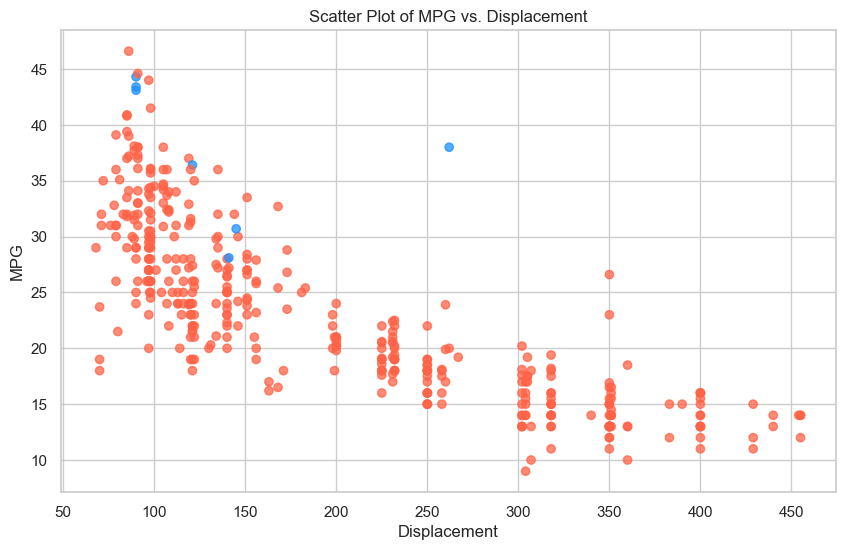

In [68]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['displacement'], data['mpg'], color=colors, alpha=0.75)

axes.set_ylabel('MPG')
axes.set_xlabel('Displacement')
axes.set_title("Scatter Plot of MPG vs. Displacement")

plt.show()
plt.close()

We see that while the diesel cars have some of the highest $mpg$, most have a fairly low $displacement$ around 100-150. Our extreme value was the only diesel car made in 82, and also has the highest $horsepower$ out of the diesel car group. Overall, I think this observation is acceptable to include.

### $One \ Final \ Note - Weight \ vs \ Displacement$

One last thing I'd like to look at is another pairwise relationship: $weight$ and $displacement$. These variables had some of the strongest negative correlations with $mpg$, so I'd like to see how they compare against each other. I'd think that there would be a relatively strong positive relationship - as $weight$ increases, you would need a bigger engine to compensate for the extra weight.

In [69]:
print('r = ', stats.pearsonr(data['displacement'], data['weight'])[0])
print('rho = ', stats.spearmanr(data['displacement'], data['weight'])[0])

r =  0.9328241468416344
rho =  0.9459855641801795


We do in fact see a very strong correlation here, with a Pearson's r of 0.93 and Spearman's r of 0.95. We can look at a scatterplot of these two features as well. I will also organize the scatterplot by those observations with an $mpg$ above 23.0 (the median for $mpg$) and those values below and equal to 23.0.

In [70]:
colors = data['mpg'].apply(lambda x: "DodgerBlue" if x > 23.0 else "Tomato")

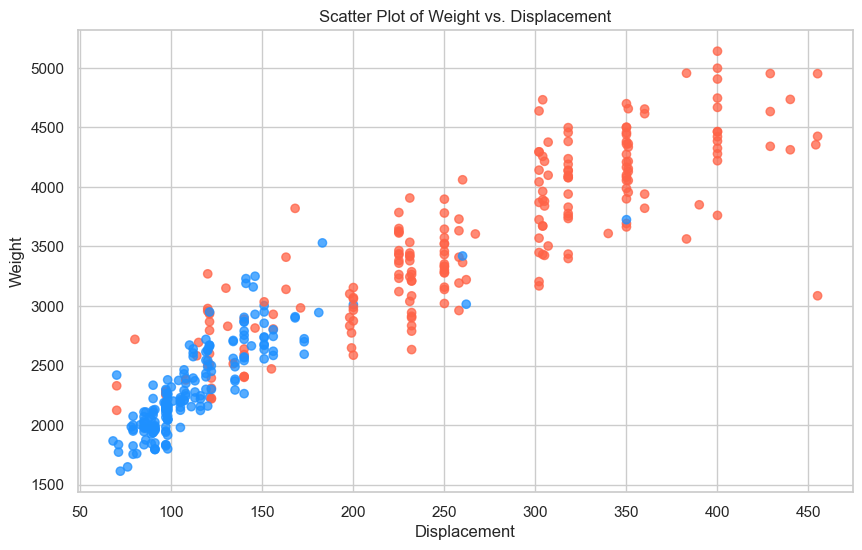

In [71]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['displacement'], data['weight'], color=colors, alpha=0.75)

axes.set_ylabel('Weight')
axes.set_xlabel('Displacement')
axes.set_title("Scatter Plot of Weight vs. Displacement")

plt.show()
plt.close()

Very interesting. We can clearly see a linear relationship here between $displacement$ and $weight$. The cars with an $mpg$ rating less than or equal to 23.0 generally fall on the high side of both $displacement$ and $weight$, whereas cars with $mpg$ values higher than 23.0 have much lower values for $displacement$ and $weight$ with a few exceptions. This makes sense since we saw that both $displacment$ and $weight$ are negatively correlated with $mpg$. There seems to be a cutoff somewhere around a $displacement$ of 200 and a $weight$ of about 2500-3000. I think $displacement$ and $weight$ will be good predictors of $mpg$ as we move forward.

## 1.3 - <a id="step3">Null & Distributional Models</a>
<a href="#contents">^ Contents</a>

Now we can look at our Null and Distributional Models. For our loss function, we want to penalize underestimates and overestimates the same, and penalize larger errors more than smaller errors. This leads us to the Mean Squared Error as our loss function. Thus, our baseline model will simply be the mean of $mpg$. Let's start with reminding ourselves of the summary statistics for $mpg$.

In [72]:
data['mpg'].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

Since the mean is 23.5, we can predict that a car will have an $mpg$ rating of 23.5. Now we can create 95% error bounds as well. Remembering that our histogram of $mpg$ in our single variable analysis was fairly symmetric, we can use standard deviation to find the bounds as ($\hat{y}$ - 1.96 * s, $\hat{y}$ + 1.96 * s), where $\hat{y}$ is the predictive value for the model/mean (using $\bar{y}$ - the actual mean), and s is the standard deviation.

In [73]:
mpg_mean = np.mean(data['mpg'])
mpg_std = np.std(data['mpg'])

lower = mpg_mean - 1.96 * mpg_std
upper = mpg_mean + 1.96 * mpg_std

print(f'({lower}, {upper})')

(8.21450110422372, 38.81464462441949)


So we predict that there's a 95% chance a car's $mpg$ rating will be between 8.2 and 38.8 or so.

For the distributional model, we can start with thinking about the data generating story. As we saw in our pairwise EDA analysis, it seems there are a good deal of factors that can affect the $mpg$ of a car - from it's weight, to how much horsepower it can provide, to whether the engine is diesel or gasoline. Since these factors are additive effects that can all contribute to $mpg$, I think we can reasonably estimate $mpg$ with the Gaussian distribution.

We also note that $mpg$ is non-zero. We know the parameters for the Gaussian distribution are the mean and standard deviation. We can estimate the mean ($\mu$) as our mean $\bar{y}$ and our standard deviation ($\sigma$) as _s_ using methods of moments estimators and the values we calculated above.

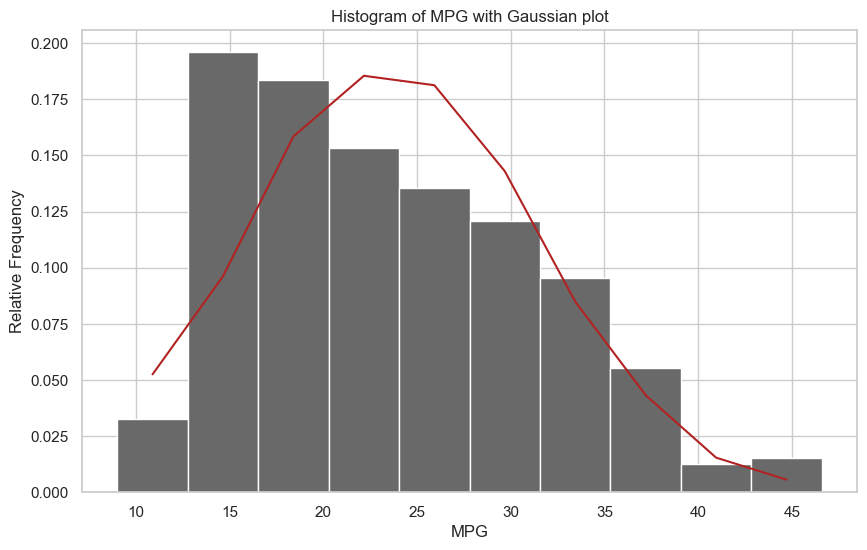

In [74]:
fig = plt.figure(figsize=(10,6))

data_mpg = data['mpg']
mu = np.mean(data_mpg)
std = np.std(data_mpg)


axes = fig.add_subplot(1,1,1)
emp_weights = np.ones(len(data_mpg)) / len(data_mpg)
n, bins, patches = axes.hist(data_mpg, color='dimgray', weights=emp_weights)

axes.set_xlabel('MPG')
axes.set_ylabel('Relative Frequency')
axes.set_title('Histogram of MPG with Gaussian plot')

xs = [(b2+b1)/2 for b1, b2 in zip(bins, bins[1:])]

sampled_data = [mu + r*std for r in np.random.standard_normal(10000)]
samp_weights = np.ones(len(sampled_data)) / len(sampled_data)
vals, base = np.histogram(sampled_data, bins=bins, weights=samp_weights)
axes.plot(xs, vals, color='firebrick')

plt.show()
plt.close()

It looks like this model overestimates $mpg$ near 10, as well as between 20-30, and underestimates $mpg$ around 15-20. We might also be inclined to look at a chart for the difference in cumulative mass between the empirical data and the distributional model. Most of the code presented here follows from *Fundamentals* page 578-579.

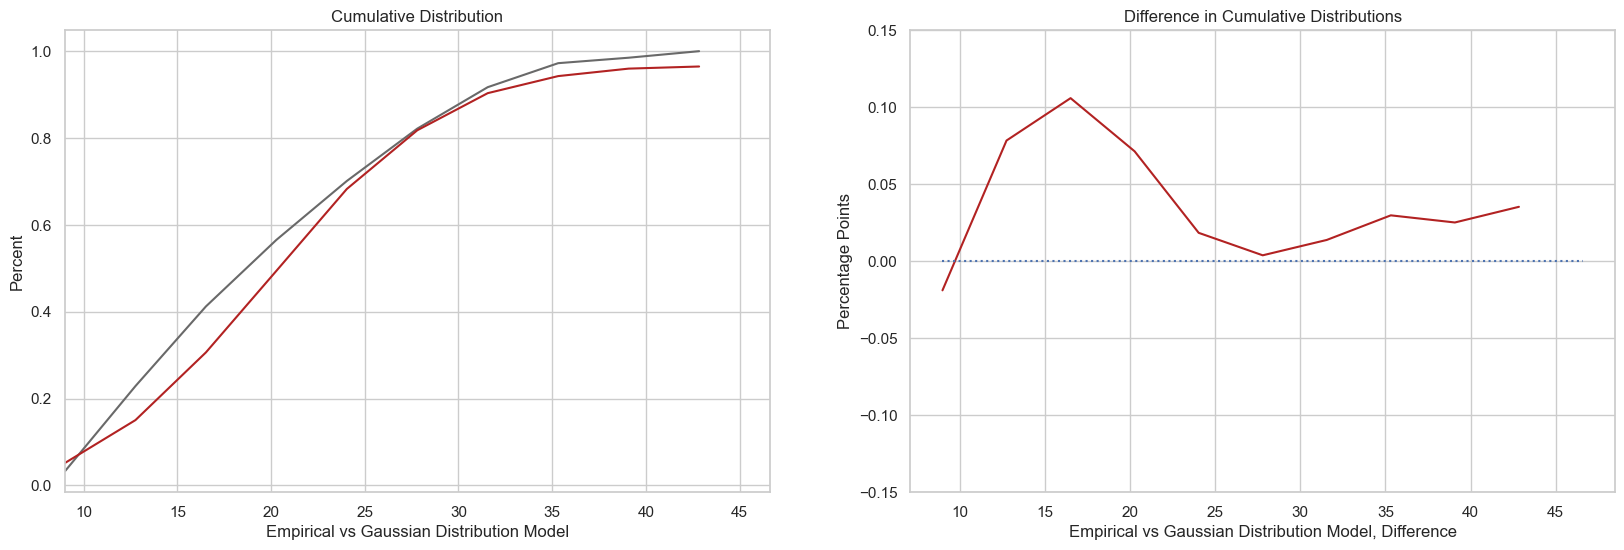

In [75]:
figure = plt.figure(figsize = (20,6))

data_mpg = data['mpg']
data_min = np.min(data_mpg)
data_max = np.max(data_mpg)
mu = np.mean(data_mpg)
std = np.std(data_mpg)

emp_weights = np.ones(len(data_mpg)) / len(data_mpg)
axes = figure.add_subplot(1,2,1)

vals, base = np.histogram(data_mpg, bins=10, weights=emp_weights)
cumulative = np.cumsum(vals)

axes.plot(base[:-1], cumulative, color='dimgray')
axes.set_xlim((data_min, data_max))

sampled_data = [mu + r*std for r in np.random.standard_normal(10000)]
samp_weights = np.ones(len(sampled_data)) / len(sampled_data)
vals2, base = np.histogram(sampled_data, bins=base, weights=samp_weights)
cumulative2 = np.cumsum(vals2)

axes.plot(base[:-1], cumulative2, color='firebrick')
axes.set_title('Cumulative Distribution')
axes.set_xlim((data_min, data_max))
axes.set_ylabel('Percent')
axes.set_xlabel('Empirical vs Gaussian Distribution Model')


axes = figure.add_subplot(1,2,2)
differences = cumulative - cumulative2
axes.plot(base[:-1], differences, color='firebrick')
axes.hlines(0, data_min, data_max, linestyles='dotted')
axes.set_ylim((-0.15,0.15))
axes.set_title('Difference in Cumulative Distributions')
axes.set_xlabel('Empirical vs Gaussian Distribution Model, Difference')
axes.set_ylabel('Percentage Points')


plt.show()
plt.close()

Similar to the histogram, we can see that we underestimate $mpg$ slightly below 10, then overestimate as we get to 12-23 roughly. And overestimate a slightly more around 35 and up.

Finally, let's make a few predictions with this model. All of our diesel cars had an $mpg$ of 30.7 or higher. For our first prediction, let's ask what is the probability that a random car will have an $mpg$ rating greater than 30.7?

In [76]:
stats.norm.sf(30.7, mpg_mean, mpg_std)

0.17866052673881883

Only about a 17.9% probability the car will have better than 30.7 $mpg$. This is not saying diesel cars cannot have a lower $mpg$, but I thought it would be interesting to look at.

Next, what is the probability that a random car will have an $mpg$ less than 18.0?

In [77]:
stats.norm.cdf(18.0, mpg_mean, mpg_std)

0.23995768043876092

Roughly 24% the car's $mpg$ will be less than 18.0 (remember our first quartile for our data was 17.5) - so this result is relatively consistent.

Finally, what value or lower would we be likely to see with 35% probability?

In [78]:
stats.norm.ppf([0.35], mpg_mean, mpg_std)

array([20.50670001])

We are likely to see $mpg$ of 20.5 and lower with 35% probability.

To sum, I think the Gaussian distribution is a fairly reasonable model for this data.

---

**PRE-SUBMISSION CHECK LIST**

Before you submit this assignent, go back and review the directions to ensure that you have followed each instruction.

* [ ] Have you completed every section and answered every question asked?
* [ ] For every question, have you described your approach and explained your results?
* [ ] Have you checked for spelling and grammar errors?
* [ ] Are your code blocks free of any errors?
* [ ] Have you deleted unused code or markdown blocks? Removed scratch calculations? Excessive raw data print outs?
* [ ] Hide all the code/output cells and make sure that you have sufficient discussion. Re-show the output cells but leave code cells hidden.
* [ ] Have you *SAVED* your notebook?
* [ ] Are you following the submission requirements for this particular assignment?